[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 26637, number of used features: 31
[LightGBM] [Info] Start training from score -5.516747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1.3407
MAE: 0.9889
R^2: 0.8154
                              feature  importance
28                     Experimental11        3409
25                  ConfUsed_to_Atoms        3136
27                   MW_to_NumOfAtoms        2639
26             Conf_to_ConfUsed_ratio        2604
4                           NumOfConf        2569
21                             MW_log        2199
22                  NumOfConfUsed_log        1645
0                              NumOfC        1513
9                              ketone        1240
7                    hydroxyl (alkyl)        1194
1                              NumOfO         943
8                            aldehyde         908
3                      NumHBondDonors         785
10                    carboxylic acid         739
17                           peroxide         696
19                 carbonylperoxyacid         630
16              carbonylperoxynitrate         608
18                      hydroperoxide         603
24           

Text(0.5, 1.0, 'Residuals vs Predictions')

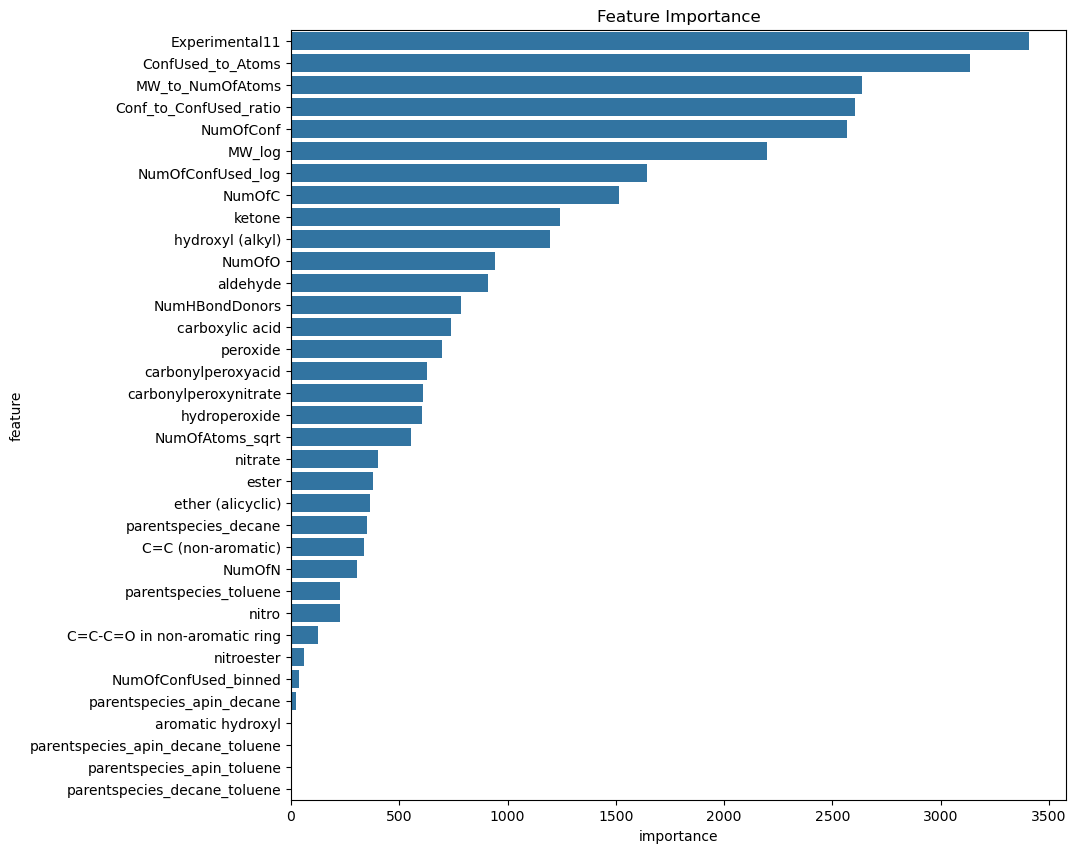

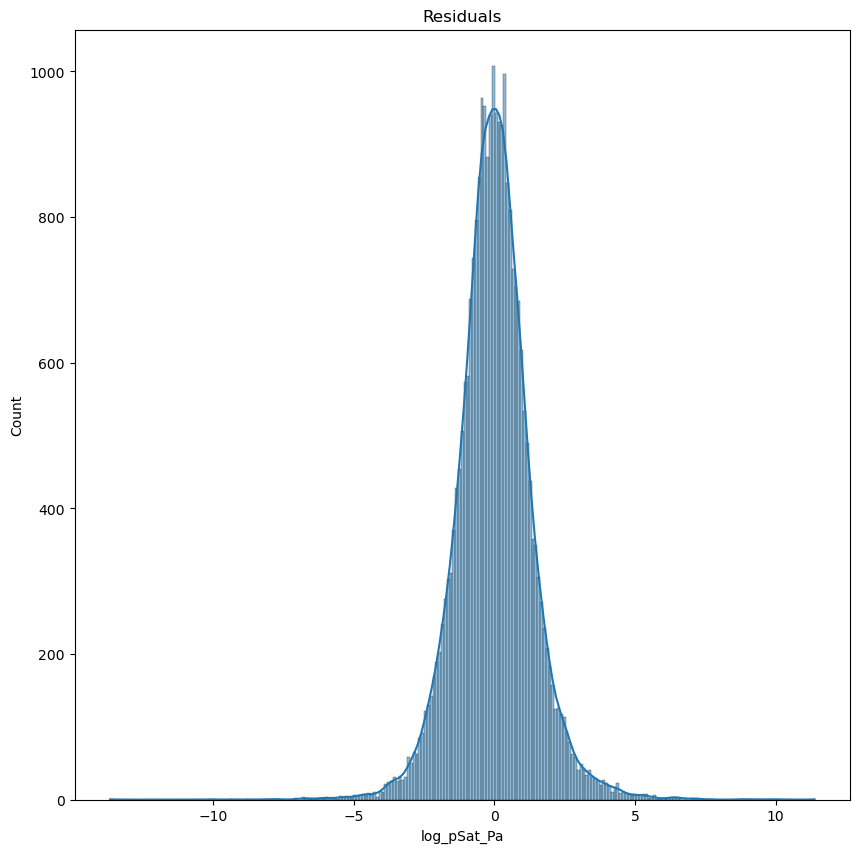

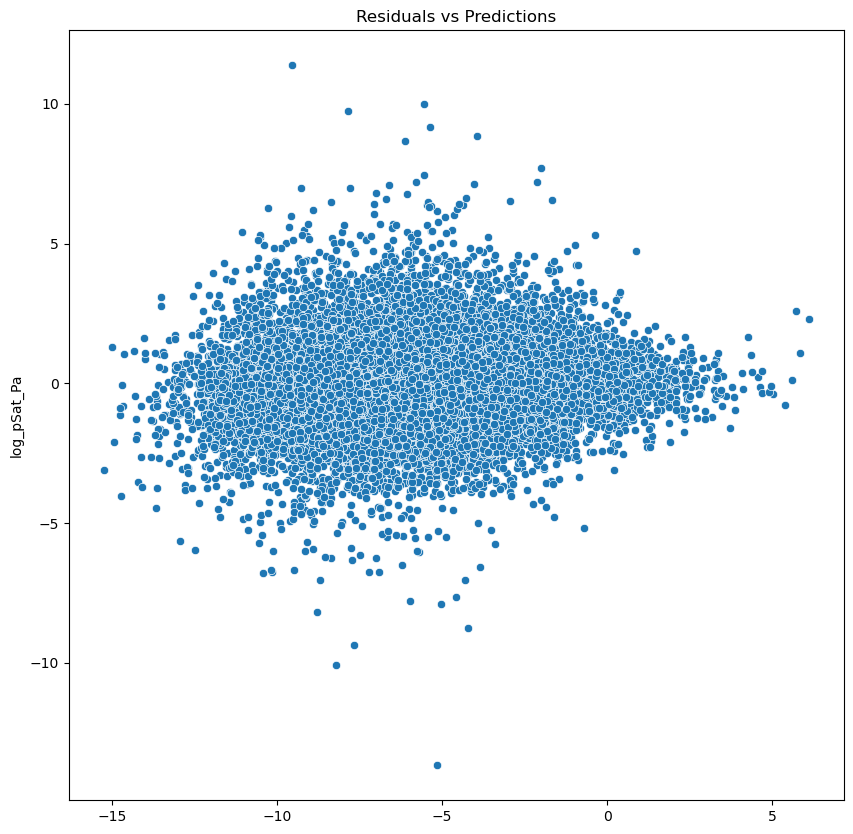

In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

def transform_features2(df):
    if 'MW' in df.columns:
        df['MW_log'] = np.log1p(df['MW'])  # log(1+x) to avoid log(0)
        df.drop(columns=['MW'], inplace=True)
    
    if "NumOfConfUsed" in df.columns:
        df['NumOfConfUsed_log'] = np.log1p(df['NumOfConfUsed'])
        df['NumOfConfUsed_binned'] = pd.cut(df['NumOfConfUsed'], bins=[0, 10, 20, 30, 40], labels=[1, 2, 3, 4])
        df.drop(columns=['NumOfConfUsed'], inplace=True)
    
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df['ConfUsed_to_Atoms'] = df['NumOfConfUsed_log'] / (df['NumOfAtoms'] + 1e-5)  # Avoid division by zero
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    if 'NumOfN_binned' in df.columns:
        df['NumOfN_binned'] = df['NumOfN_binned'].astype(int)  # Convert categories to integers

    if 'NumOfConfUsed_binned' in df.columns:
        df['NumOfConfUsed_binned'] = df['NumOfConfUsed_binned'].astype(int)  # Convert categories to integers
        
    df['Conf_to_ConfUsed_ratio'] = df['NumOfConf'] / df['NumOfConfUsed_binned']
    df['MW_to_NumOfAtoms'] = df['MW_log'] / df['NumOfAtoms_sqrt']
    df['Experimental11'] = df['NumHBondDonors'] / df['NumOfConf'] # addition to best2
    return df

# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features2(train.copy())
test_transformed = transform_features2(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)

# Separate the parentspecies columns
parentspecies_train = train_transformed.filter(like='parentspecies')
parentspecies_test = test_transformed.filter(like='parentspecies')

# Drop the parentspecies columns from the transformed data
train_transformed = train_transformed.drop(columns=parentspecies_train.columns)
test_transformed = test_transformed.drop(columns=parentspecies_test.columns)

# Save the column names before scaling
train_columns = train_transformed.columns
test_columns = test_transformed.columns

# Scale numerical features
scaler = StandardScaler()
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)

# Convert scaled numerical features back to DataFrame
train_transformed = pd.DataFrame(train_transformed, columns=train_columns)
test_transformed = pd.DataFrame(test_transformed, columns=test_columns)

# Add the parentspecies columns back to the scaled numerical features
train_transformed = pd.concat([train_transformed, parentspecies_train.reset_index(drop=True)], axis=1)
test_transformed = pd.concat([test_transformed, parentspecies_test.reset_index(drop=True)], axis=1)

best_params = {'n_estimators': 612, 'learning_rate': 0.03253420017567533, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7456333280664998, 'colsample_bytree': 0.9137393037318097, 'reg_alpha': 0.7026860907781649, 'reg_lambda': 0.7187304208680759}
model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("lgbm_best_cur.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")

# plot residuals
residuals = target - train_predictions
plt.figure(figsize=(10, 10))
sns.histplot(residuals, kde=True)
plt.title("Residuals")

# plot redualls as scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x=train_predictions, y=residuals)
plt.title("Residuals vs Predictions")



Text(0.5, 1.0, 'Extreme Residuals vs Predictions')

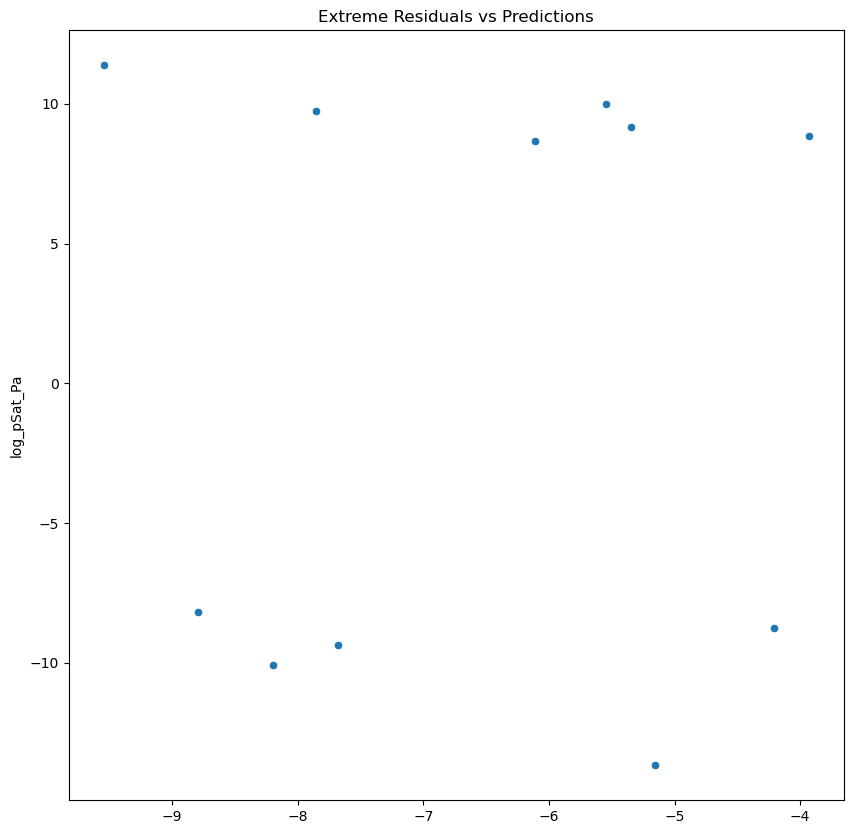

In [2]:
# plot the extreme residuals
extreme_residuals = residuals[np.abs(residuals) > 8]
extreme_predictions = train_predictions[np.abs(residuals) > 8]
extreme_targets = target[np.abs(residuals) > 8]
extreme_ids = train.index[np.abs(residuals) > 8]
extreme_data = pd.DataFrame({"ID": extreme_ids, "TARGET": extreme_targets, "PREDICTION": extreme_predictions, "RESIDUAL": extreme_residuals})
extreme_data.to_csv("extreme_residuals.csv", index=False)

#plot these residuals
plt.figure(figsize=(10, 10))
sns.scatterplot(x=extreme_predictions, y=extreme_residuals)
plt.title("Extreme Residuals vs Predictions")


<Axes: >

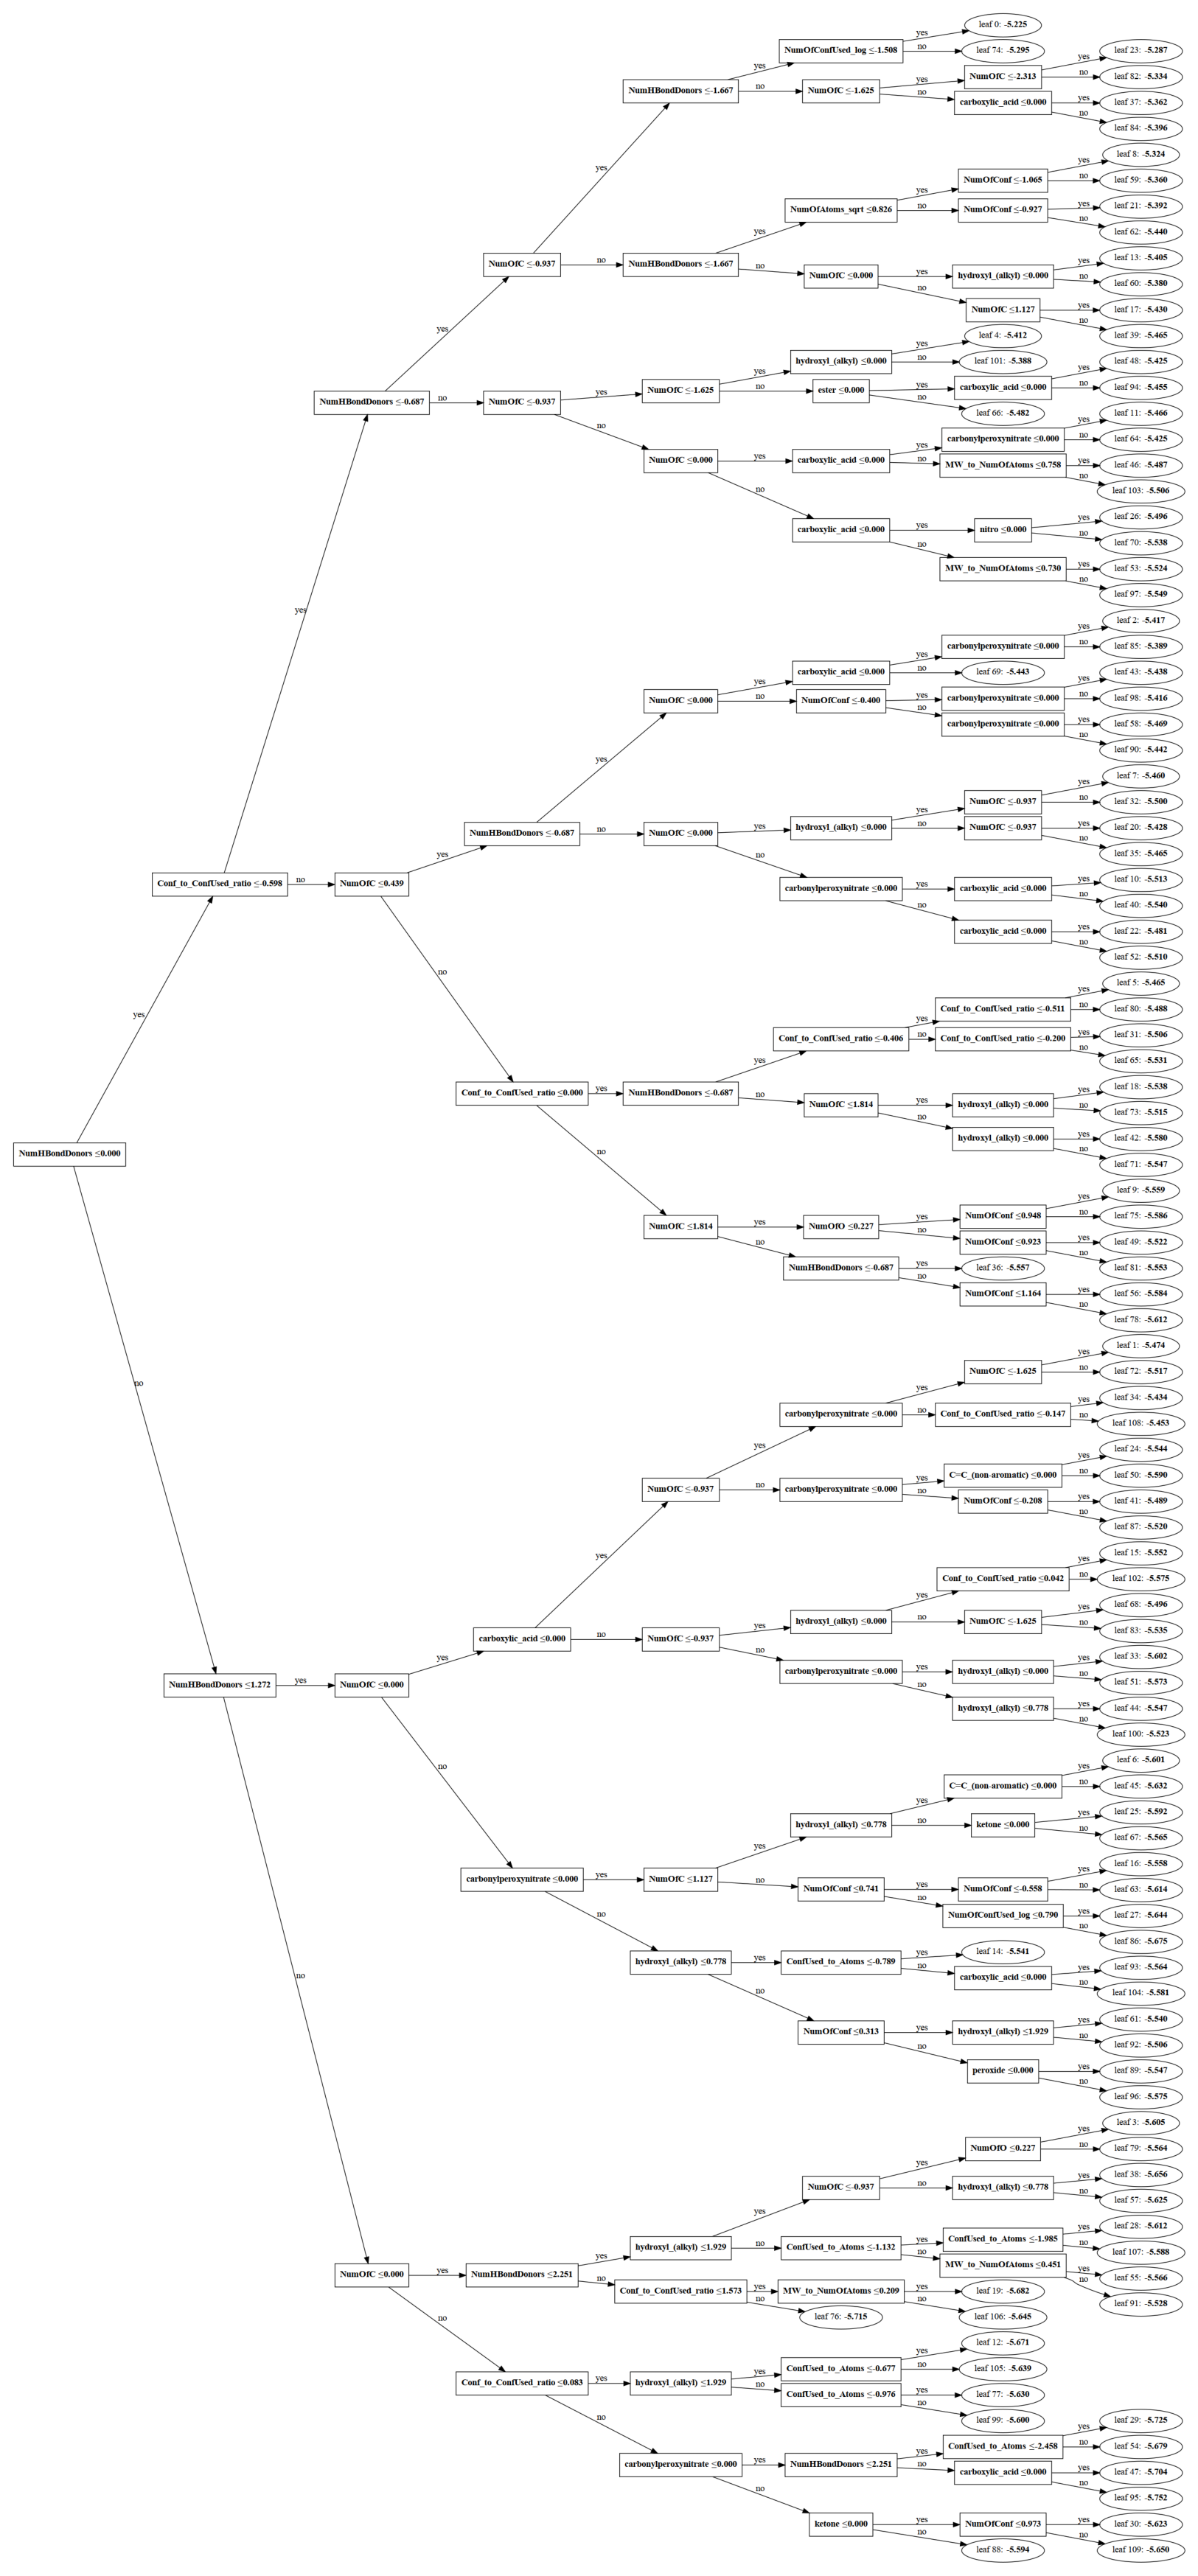

In [7]:
# plot the lgbm model
!pip install graphviz
lgb.plot_tree(model, figsize=(30, 30), dpi=150)